In [1]:

import numpy as np


import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

In [2]:
import pandas as pd

In [3]:
from tensorflow.keras.layers import Activation, Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization

In [4]:
train_path= './train'
test_path= './test'

In [5]:
train_datagen = ImageDataGenerator(rescale=1.0/255,
                                   zoom_range= 0.2,
                                   horizontal_flip=True,
                                   shear_range=0.2)

test_datagen = ImageDataGenerator(rescale=1.0/255)

#Read our images to the data augmentations
#Generates batches of augmented data
train = train_datagen.flow_from_directory(train_path,
                                          color_mode = 'grayscale',
                                          target_size = (48, 48),
                                          batch_size = 64,
                                          shuffle=True,
                                          class_mode = 'categorical')



test = test_datagen.flow_from_directory(test_path,
                                        color_mode = 'grayscale',
                                        target_size = (48, 48),
                                        batch_size = 64,
                                        shuffle=True,
                                        class_mode = 'categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [26]:
train

In [6]:
def focal_loss(gamma=2., alpha=4.):

    gamma = float(gamma)
    alpha = float(alpha)

    def focal_loss_fixed(y_true, y_pred):
        """Focal loss for multi-classification
        FL(p_t)=-alpha(1-p_t)^{gamma}ln(p_t)
        Notice: y_pred is probability after softmax
        gradient is d(Fl)/d(p_t) not d(Fl)/d(x) as described in paper
        d(Fl)/d(p_t) * [p_t(1-p_t)] = d(Fl)/d(x)
        Focal Loss for Dense Object Detection
        https://arxiv.org/abs/1708.02002

        Arguments:
            y_true {tensor} -- ground truth labels, shape of [batch_size, num_cls]
            y_pred {tensor} -- model's output, shape of [batch_size, num_cls]

        Keyword Arguments:
            gamma {float} -- (default: {2.0})
            alpha {float} -- (default: {4.0})

        Returns:
            [tensor] -- loss.
        """
        epsilon = 1.e-9
        y_true = tf.convert_to_tensor(y_true, tf.float32)
        y_pred = tf.convert_to_tensor(y_pred, tf.float32)

        model_out = tf.add(y_pred, epsilon)
        ce = tf.multiply(y_true, -tf.math.log(model_out))
        weight = tf.multiply(y_true, tf.math.pow(tf.subtract(1., model_out), gamma))
        fl = tf.multiply(alpha, tf.multiply(weight, ce))
        reduced_fl = tf.reduce_max(fl, axis=1)
        return tf.reduce_mean(reduced_fl)
    return focal_loss_fixed

In [9]:
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.utils import class_weight

class_weights = class_weight.compute_class_weight(class_weight='balanced', 
                                                  classes=np.unique(train.classes), 
                                                  y=train.classes)
class_weights = dict(zip(np.unique(train.classes),class_weights))

filepath = '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5' #saves our best model to this location with custom name
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2,patience=5, min_delta=0.0001, verbose=1),
             tf.keras.callbacks.ModelCheckpoint(filepath=filepath, monitor='val_loss',verbose=1, save_best_only=True, mode='min'),
             tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3, verbose=1,restore_best_weights=True)]


model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=focal_loss(alpha=1),
              metrics=['accuracy'])

In [10]:
print(class_weights)


{0: 1.0266046844269623, 1: 9.406618610747051, 2: 1.0010460615781582, 3: 0.5684387684387684, 4: 0.8260394187886635, 5: 0.8491274770777877, 6: 1.293372978330405}


In [8]:
model = tf.keras.models.Sequential()
model.add(layers.Conv2D(32,(3,3),strides=(1,1),padding="valid",activation="relu",input_shape=(48,48,1)))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Conv2D(64,(3,3),activation="relu"))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Conv2D(256,(3,3),activation="relu"))
model.add(layers.MaxPool2D(2,2))
model.add(BatchNormalization())
model.add(Dropout(0.15))

model.add(layers.Flatten())
model.add(layers.Dense(64,activation="relu"))
model.add(BatchNormalization())
model.add(Dropout(0.2))


model.add(layers.Dense(7,activation="softmax"))

#loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
optim = tf.keras.optimizers.Adam(lr=0.001)
metrics = ["accuracy"]
#model.compile(optimizer = optim, loss=loss,metrics=metrics)

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 23, 23, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 23, 23, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 23, 23, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 10, 10, 64)       0

C:\Users\Administrator\anaconda3\envs\tf\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [11]:
model.fit(train,epochs=1500,validation_data=test,verbose=1,class_weight=class_weights)


Epoch 1/1500
449/449 [==============================] - 32s 70ms/step - loss: 1.7638 - accuracy: 0.2004 - val_loss: 1.3885 - val_accuracy: 0.2591
Epoch 2/1500
449/449 [==============================] - 31s 69ms/step - loss: 1.4945 - accuracy: 0.2419 - val_loss: 1.1773 - val_accuracy: 0.3468
Epoch 3/1500
449/449 [==============================] - 31s 70ms/step - loss: 1.3814 - accuracy: 0.2872 - val_loss: 1.1225 - val_accuracy: 0.3714
Epoch 4/1500
449/449 [==============================] - 31s 69ms/step - loss: 1.3027 - accuracy: 0.3164 - val_loss: 1.0810 - val_accuracy: 0.3909
Epoch 5/1500
449/449 [==============================] - 31s 70ms/step - loss: 1.2347 - accuracy: 0.3429 - val_loss: 1.0536 - val_accuracy: 0.4014
Epoch 6/1500
449/449 [==============================] - 31s 70ms/step - loss: 1.1952 - accuracy: 0.3543 - val_loss: 0.9912 - val_accuracy: 0.4301
Epoch 7/1500
449/449 [==============================] - 31s 69ms/step - loss: 1.1388 - accuracy: 0.3742 - val_loss: 1.0129 -

Epoch 57/1500
449/449 [==============================] - 30s 68ms/step - loss: 0.6616 - accuracy: 0.5805 - val_loss: 0.6297 - val_accuracy: 0.6035
Epoch 58/1500
449/449 [==============================] - 30s 67ms/step - loss: 0.6556 - accuracy: 0.5811 - val_loss: 0.6171 - val_accuracy: 0.6088
Epoch 59/1500
449/449 [==============================] - 30s 67ms/step - loss: 0.6553 - accuracy: 0.5785 - val_loss: 0.6246 - val_accuracy: 0.6046
Epoch 60/1500
449/449 [==============================] - 30s 67ms/step - loss: 0.6485 - accuracy: 0.5786 - val_loss: 0.6220 - val_accuracy: 0.6076
Epoch 61/1500
449/449 [==============================] - 30s 67ms/step - loss: 0.6461 - accuracy: 0.5853 - val_loss: 0.6223 - val_accuracy: 0.6062
Epoch 62/1500
449/449 [==============================] - 30s 67ms/step - loss: 0.6449 - accuracy: 0.5843 - val_loss: 0.6422 - val_accuracy: 0.5946
Epoch 63/1500
449/449 [==============================] - 30s 68ms/step - loss: 0.6446 - accuracy: 0.5863 - val_loss: 0

449/449 [==============================] - 31s 69ms/step - loss: 0.5034 - accuracy: 0.6501 - val_loss: 0.5826 - val_accuracy: 0.6300
Epoch 168/1500
449/449 [==============================] - 31s 69ms/step - loss: 0.5057 - accuracy: 0.6468 - val_loss: 0.5647 - val_accuracy: 0.6356
Epoch 169/1500
449/449 [==============================] - 31s 69ms/step - loss: 0.5065 - accuracy: 0.6486 - val_loss: 0.5717 - val_accuracy: 0.6353
Epoch 170/1500
449/449 [==============================] - 31s 70ms/step - loss: 0.5069 - accuracy: 0.6454 - val_loss: 0.5745 - val_accuracy: 0.6347
Epoch 171/1500
449/449 [==============================] - 31s 70ms/step - loss: 0.5052 - accuracy: 0.6496 - val_loss: 0.5881 - val_accuracy: 0.6305
Epoch 172/1500
449/449 [==============================] - 31s 70ms/step - loss: 0.5025 - accuracy: 0.6502 - val_loss: 0.5731 - val_accuracy: 0.6395
Epoch 173/1500
449/449 [==============================] - 31s 70ms/step - loss: 0.5019 - accuracy: 0.6499 - val_loss: 0.5682 - 

449/449 [==============================] - 32s 71ms/step - loss: 0.4465 - accuracy: 0.6758 - val_loss: 0.5711 - val_accuracy: 0.6414
Epoch 278/1500
449/449 [==============================] - 32s 71ms/step - loss: 0.4496 - accuracy: 0.6716 - val_loss: 0.5801 - val_accuracy: 0.6369
Epoch 279/1500
449/449 [==============================] - 32s 70ms/step - loss: 0.4481 - accuracy: 0.6741 - val_loss: 0.5717 - val_accuracy: 0.6417
Epoch 280/1500
449/449 [==============================] - 32s 71ms/step - loss: 0.4483 - accuracy: 0.6748 - val_loss: 0.5778 - val_accuracy: 0.6386
Epoch 281/1500
449/449 [==============================] - 32s 71ms/step - loss: 0.4493 - accuracy: 0.6780 - val_loss: 0.5791 - val_accuracy: 0.6400
Epoch 282/1500
449/449 [==============================] - 32s 70ms/step - loss: 0.4471 - accuracy: 0.6714 - val_loss: 0.5739 - val_accuracy: 0.6445
Epoch 283/1500
449/449 [==============================] - 32s 70ms/step - loss: 0.4438 - accuracy: 0.6745 - val_loss: 0.5773 - 

449/449 [==============================] - 31s 70ms/step - loss: 0.4131 - accuracy: 0.6904 - val_loss: 0.5884 - val_accuracy: 0.6457
Epoch 388/1500
449/449 [==============================] - 32s 70ms/step - loss: 0.4229 - accuracy: 0.6862 - val_loss: 0.5984 - val_accuracy: 0.6414
Epoch 389/1500
449/449 [==============================] - 31s 70ms/step - loss: 0.4163 - accuracy: 0.6885 - val_loss: 0.5902 - val_accuracy: 0.6452
Epoch 390/1500
449/449 [==============================] - 32s 71ms/step - loss: 0.4155 - accuracy: 0.6869 - val_loss: 0.5964 - val_accuracy: 0.6415
Epoch 391/1500
449/449 [==============================] - 32s 70ms/step - loss: 0.4211 - accuracy: 0.6852 - val_loss: 0.5885 - val_accuracy: 0.6431
Epoch 392/1500
449/449 [==============================] - 31s 68ms/step - loss: 0.4178 - accuracy: 0.6887 - val_loss: 0.5839 - val_accuracy: 0.6473
Epoch 393/1500
449/449 [==============================] - 31s 68ms/step - loss: 0.4135 - accuracy: 0.6914 - val_loss: 0.5882 - 

449/449 [==============================] - 31s 68ms/step - loss: 0.4007 - accuracy: 0.6959 - val_loss: 0.5921 - val_accuracy: 0.6516
Epoch 498/1500
449/449 [==============================] - 31s 68ms/step - loss: 0.3972 - accuracy: 0.6959 - val_loss: 0.5895 - val_accuracy: 0.6486
Epoch 499/1500
449/449 [==============================] - 31s 68ms/step - loss: 0.3958 - accuracy: 0.6951 - val_loss: 0.5978 - val_accuracy: 0.6466
Epoch 500/1500
449/449 [==============================] - 31s 69ms/step - loss: 0.4005 - accuracy: 0.6943 - val_loss: 0.5937 - val_accuracy: 0.6492
Epoch 501/1500
449/449 [==============================] - 31s 68ms/step - loss: 0.3982 - accuracy: 0.6965 - val_loss: 0.5993 - val_accuracy: 0.6467
Epoch 502/1500
449/449 [==============================] - 31s 68ms/step - loss: 0.3971 - accuracy: 0.6981 - val_loss: 0.6084 - val_accuracy: 0.6428
Epoch 503/1500
449/449 [==============================] - 31s 68ms/step - loss: 0.3959 - accuracy: 0.6983 - val_loss: 0.5918 - 

449/449 [==============================] - 42s 94ms/step - loss: 0.3818 - accuracy: 0.7036 - val_loss: 0.6067 - val_accuracy: 0.6506
Epoch 608/1500
449/449 [==============================] - 43s 96ms/step - loss: 0.3811 - accuracy: 0.7053 - val_loss: 0.5952 - val_accuracy: 0.6450
Epoch 609/1500
449/449 [==============================] - 43s 95ms/step - loss: 0.3857 - accuracy: 0.7038 - val_loss: 0.6062 - val_accuracy: 0.6509
Epoch 610/1500
449/449 [==============================] - 42s 94ms/step - loss: 0.3838 - accuracy: 0.7028 - val_loss: 0.5953 - val_accuracy: 0.6484
Epoch 611/1500
449/449 [==============================] - 40s 89ms/step - loss: 0.3821 - accuracy: 0.7033 - val_loss: 0.6000 - val_accuracy: 0.6485
Epoch 612/1500
449/449 [==============================] - 40s 89ms/step - loss: 0.3867 - accuracy: 0.7007 - val_loss: 0.5999 - val_accuracy: 0.6459
Epoch 613/1500
449/449 [==============================] - 44s 99ms/step - loss: 0.3822 - accuracy: 0.7037 - val_loss: 0.5956 - 

449/449 [==============================] - 53s 117ms/step - loss: 0.3723 - accuracy: 0.7084 - val_loss: 0.6049 - val_accuracy: 0.6496
Epoch 718/1500
449/449 [==============================] - 52s 115ms/step - loss: 0.3767 - accuracy: 0.7097 - val_loss: 0.6079 - val_accuracy: 0.6482
Epoch 719/1500
449/449 [==============================] - 53s 117ms/step - loss: 0.3773 - accuracy: 0.7061 - val_loss: 0.6139 - val_accuracy: 0.6435
Epoch 720/1500
449/449 [==============================] - 40s 89ms/step - loss: 0.3766 - accuracy: 0.7065 - val_loss: 0.5963 - val_accuracy: 0.6532
Epoch 721/1500
449/449 [==============================] - 45s 100ms/step - loss: 0.3696 - accuracy: 0.7128 - val_loss: 0.6329 - val_accuracy: 0.6415
Epoch 722/1500
449/449 [==============================] - 52s 117ms/step - loss: 0.3770 - accuracy: 0.7106 - val_loss: 0.6026 - val_accuracy: 0.6500
Epoch 723/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3774 - accuracy: 0.7077 - val_loss: 0.6

449/449 [==============================] - 53s 119ms/step - loss: 0.3659 - accuracy: 0.7087 - val_loss: 0.6063 - val_accuracy: 0.6535
Epoch 773/1500
449/449 [==============================] - 53s 119ms/step - loss: 0.3720 - accuracy: 0.7036 - val_loss: 0.6068 - val_accuracy: 0.6532
Epoch 774/1500
449/449 [==============================] - 54s 121ms/step - loss: 0.3672 - accuracy: 0.7112 - val_loss: 0.6139 - val_accuracy: 0.6482
Epoch 775/1500
449/449 [==============================] - 54s 120ms/step - loss: 0.3710 - accuracy: 0.7122 - val_loss: 0.6035 - val_accuracy: 0.6565
Epoch 776/1500
449/449 [==============================] - 55s 122ms/step - loss: 0.3747 - accuracy: 0.7043 - val_loss: 0.6207 - val_accuracy: 0.6454
Epoch 777/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3703 - accuracy: 0.7096 - val_loss: 0.6259 - val_accuracy: 0.6461
Epoch 778/1500
449/449 [==============================] - 54s 120ms/step - loss: 0.3654 - accuracy: 0.7113 - val_loss: 0.

449/449 [==============================] - 54s 121ms/step - loss: 0.3700 - accuracy: 0.7112 - val_loss: 0.6095 - val_accuracy: 0.6517
Epoch 828/1500
449/449 [==============================] - 55s 122ms/step - loss: 0.3649 - accuracy: 0.7092 - val_loss: 0.6037 - val_accuracy: 0.6549
Epoch 829/1500
449/449 [==============================] - 55s 121ms/step - loss: 0.3711 - accuracy: 0.7068 - val_loss: 0.6147 - val_accuracy: 0.6484
Epoch 830/1500
449/449 [==============================] - 54s 119ms/step - loss: 0.3675 - accuracy: 0.7110 - val_loss: 0.6120 - val_accuracy: 0.6489
Epoch 831/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3627 - accuracy: 0.7138 - val_loss: 0.6122 - val_accuracy: 0.6489
Epoch 832/1500
449/449 [==============================] - 55s 121ms/step - loss: 0.3662 - accuracy: 0.7113 - val_loss: 0.6086 - val_accuracy: 0.6486
Epoch 833/1500
449/449 [==============================] - 55s 123ms/step - loss: 0.3705 - accuracy: 0.7078 - val_loss: 0.

449/449 [==============================] - 56s 125ms/step - loss: 0.3681 - accuracy: 0.7123 - val_loss: 0.6198 - val_accuracy: 0.6408
Epoch 883/1500
449/449 [==============================] - 56s 125ms/step - loss: 0.3633 - accuracy: 0.7128 - val_loss: 0.6293 - val_accuracy: 0.6397
Epoch 884/1500
449/449 [==============================] - 56s 125ms/step - loss: 0.3695 - accuracy: 0.7067 - val_loss: 0.6160 - val_accuracy: 0.6525
Epoch 885/1500
449/449 [==============================] - 56s 124ms/step - loss: 0.3611 - accuracy: 0.7129 - val_loss: 0.6064 - val_accuracy: 0.6558
Epoch 886/1500
449/449 [==============================] - 56s 124ms/step - loss: 0.3615 - accuracy: 0.7137 - val_loss: 0.6077 - val_accuracy: 0.6525
Epoch 887/1500
449/449 [==============================] - 56s 124ms/step - loss: 0.3641 - accuracy: 0.7158 - val_loss: 0.6126 - val_accuracy: 0.6510
Epoch 888/1500
449/449 [==============================] - 56s 125ms/step - loss: 0.3617 - accuracy: 0.7159 - val_loss: 0.

449/449 [==============================] - 58s 129ms/step - loss: 0.3624 - accuracy: 0.7133 - val_loss: 0.6215 - val_accuracy: 0.6493
Epoch 938/1500
449/449 [==============================] - 58s 129ms/step - loss: 0.3655 - accuracy: 0.7124 - val_loss: 0.6094 - val_accuracy: 0.6570
Epoch 939/1500
449/449 [==============================] - 57s 127ms/step - loss: 0.3563 - accuracy: 0.7174 - val_loss: 0.6125 - val_accuracy: 0.6558
Epoch 940/1500
449/449 [==============================] - 57s 127ms/step - loss: 0.3583 - accuracy: 0.7188 - val_loss: 0.6082 - val_accuracy: 0.6525
Epoch 941/1500
449/449 [==============================] - 58s 129ms/step - loss: 0.3596 - accuracy: 0.7173 - val_loss: 0.6126 - val_accuracy: 0.6464
Epoch 942/1500
449/449 [==============================] - 59s 130ms/step - loss: 0.3528 - accuracy: 0.7177 - val_loss: 0.6022 - val_accuracy: 0.6556
Epoch 943/1500
449/449 [==============================] - 58s 129ms/step - loss: 0.3617 - accuracy: 0.7181 - val_loss: 0.

449/449 [==============================] - 59s 131ms/step - loss: 0.3534 - accuracy: 0.7209 - val_loss: 0.6135 - val_accuracy: 0.6524
Epoch 993/1500
449/449 [==============================] - 58s 129ms/step - loss: 0.3570 - accuracy: 0.7203 - val_loss: 0.6204 - val_accuracy: 0.6532
Epoch 994/1500
449/449 [==============================] - 59s 131ms/step - loss: 0.3595 - accuracy: 0.7122 - val_loss: 0.6056 - val_accuracy: 0.6560
Epoch 995/1500
449/449 [==============================] - 60s 133ms/step - loss: 0.3566 - accuracy: 0.7221 - val_loss: 0.6126 - val_accuracy: 0.6556
Epoch 996/1500
449/449 [==============================] - 59s 131ms/step - loss: 0.3609 - accuracy: 0.7146 - val_loss: 0.6358 - val_accuracy: 0.6417
Epoch 997/1500
449/449 [==============================] - 57s 127ms/step - loss: 0.3593 - accuracy: 0.7182 - val_loss: 0.6164 - val_accuracy: 0.6534
Epoch 998/1500
449/449 [==============================] - 58s 130ms/step - loss: 0.3595 - accuracy: 0.7150 - val_loss: 0.

Epoch 1047/1500
449/449 [==============================] - 58s 128ms/step - loss: 0.3563 - accuracy: 0.7171 - val_loss: 0.6190 - val_accuracy: 0.6516
Epoch 1048/1500
449/449 [==============================] - 58s 129ms/step - loss: 0.3507 - accuracy: 0.7214 - val_loss: 0.6200 - val_accuracy: 0.6558
Epoch 1049/1500
449/449 [==============================] - 58s 129ms/step - loss: 0.3576 - accuracy: 0.7194 - val_loss: 0.6101 - val_accuracy: 0.6576
Epoch 1050/1500
449/449 [==============================] - 58s 130ms/step - loss: 0.3586 - accuracy: 0.7201 - val_loss: 0.6265 - val_accuracy: 0.6493
Epoch 1051/1500
449/449 [==============================] - 58s 130ms/step - loss: 0.3580 - accuracy: 0.7195 - val_loss: 0.6170 - val_accuracy: 0.6512
Epoch 1052/1500
449/449 [==============================] - 57s 128ms/step - loss: 0.3562 - accuracy: 0.7168 - val_loss: 0.6231 - val_accuracy: 0.6500
Epoch 1053/1500
449/449 [==============================] - 59s 131ms/step - loss: 0.3606 - accuracy:

Epoch 1156/1500
449/449 [==============================] - 61s 137ms/step - loss: 0.3448 - accuracy: 0.7221 - val_loss: 0.6230 - val_accuracy: 0.6527
Epoch 1157/1500
449/449 [==============================] - 61s 137ms/step - loss: 0.3525 - accuracy: 0.7194 - val_loss: 0.6205 - val_accuracy: 0.6578
Epoch 1158/1500
449/449 [==============================] - 61s 136ms/step - loss: 0.3521 - accuracy: 0.7203 - val_loss: 0.6172 - val_accuracy: 0.6585
Epoch 1159/1500
449/449 [==============================] - 61s 136ms/step - loss: 0.3498 - accuracy: 0.7209 - val_loss: 0.6182 - val_accuracy: 0.6546
Epoch 1160/1500
449/449 [==============================] - 62s 137ms/step - loss: 0.3515 - accuracy: 0.7177 - val_loss: 0.6240 - val_accuracy: 0.6524
Epoch 1161/1500
449/449 [==============================] - 62s 138ms/step - loss: 0.3558 - accuracy: 0.7218 - val_loss: 0.6104 - val_accuracy: 0.6553
Epoch 1162/1500
449/449 [==============================] - 61s 135ms/step - loss: 0.3503 - accuracy:

Epoch 1265/1500
449/449 [==============================] - 78s 173ms/step - loss: 0.3482 - accuracy: 0.7241 - val_loss: 0.6164 - val_accuracy: 0.6592
Epoch 1266/1500
449/449 [==============================] - 79s 176ms/step - loss: 0.3478 - accuracy: 0.7206 - val_loss: 0.6164 - val_accuracy: 0.6567
Epoch 1267/1500
449/449 [==============================] - 78s 174ms/step - loss: 0.3465 - accuracy: 0.7225 - val_loss: 0.6293 - val_accuracy: 0.6531
Epoch 1268/1500
449/449 [==============================] - 78s 174ms/step - loss: 0.3507 - accuracy: 0.7230 - val_loss: 0.6182 - val_accuracy: 0.6563
Epoch 1269/1500
449/449 [==============================] - 78s 174ms/step - loss: 0.3442 - accuracy: 0.7238 - val_loss: 0.6203 - val_accuracy: 0.6493
Epoch 1270/1500
449/449 [==============================] - 78s 174ms/step - loss: 0.3550 - accuracy: 0.7202 - val_loss: 0.6239 - val_accuracy: 0.6538
Epoch 1271/1500
449/449 [==============================] - 78s 173ms/step - loss: 0.3464 - accuracy:

Epoch 1374/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3440 - accuracy: 0.7278 - val_loss: 0.6267 - val_accuracy: 0.6503
Epoch 1375/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3445 - accuracy: 0.7267 - val_loss: 0.6245 - val_accuracy: 0.6527
Epoch 1376/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3431 - accuracy: 0.7256 - val_loss: 0.6278 - val_accuracy: 0.6474
Epoch 1377/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3427 - accuracy: 0.7261 - val_loss: 0.6200 - val_accuracy: 0.6569
Epoch 1378/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3434 - accuracy: 0.7244 - val_loss: 0.6254 - val_accuracy: 0.6496
Epoch 1379/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3465 - accuracy: 0.7238 - val_loss: 0.6329 - val_accuracy: 0.6480
Epoch 1380/1500
449/449 [==============================] - 53s 118ms/step - loss: 0.3414 - accuracy:

Epoch 1483/1500
449/449 [==============================] - 54s 120ms/step - loss: 0.3446 - accuracy: 0.7274 - val_loss: 0.6242 - val_accuracy: 0.6548
Epoch 1484/1500
449/449 [==============================] - 54s 120ms/step - loss: 0.3393 - accuracy: 0.7287 - val_loss: 0.6195 - val_accuracy: 0.6527
Epoch 1485/1500
449/449 [==============================] - 54s 120ms/step - loss: 0.3454 - accuracy: 0.7278 - val_loss: 0.6205 - val_accuracy: 0.6549
Epoch 1486/1500
449/449 [==============================] - 55s 123ms/step - loss: 0.3396 - accuracy: 0.7261 - val_loss: 0.6171 - val_accuracy: 0.6559
Epoch 1487/1500
449/449 [==============================] - 55s 123ms/step - loss: 0.3386 - accuracy: 0.7304 - val_loss: 0.6279 - val_accuracy: 0.6523
Epoch 1488/1500
449/449 [==============================] - 54s 121ms/step - loss: 0.3389 - accuracy: 0.7261 - val_loss: 0.6219 - val_accuracy: 0.6535
Epoch 1489/1500
449/449 [==============================] - 54s 121ms/step - loss: 0.3368 - accuracy:

In [12]:
train_dir= './train'
validation_dir= './test'

In [13]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
                    rescale=1./255,
					rotation_range=30,
					shear_range=0.3,
					zoom_range=0.3,
					width_shift_range=0.4,
					height_shift_range=0.4,
					horizontal_flip=True,
					fill_mode='nearest')
validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(48,48),
        batch_size=28709,
        color_mode = "grayscale",
        shuffle=True,
        class_mode='categorical')
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=(48, 48),
        batch_size=7178,
        color_mode = "grayscale",
        shuffle=True,
        class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [14]:
train_images,train_labels = next(train_generator)
test_images,test_labels = next(validation_generator)


In [15]:
train_labels.shape

(28709, 7)

In [16]:
preds = model.predict(test_images)

In [17]:
test_labels_new = np.array([np.argmax(test_labels[i]) for i in range(7178)])
test_labels_new

array([4, 0, 3, ..., 3, 4, 3], dtype=int64)

In [18]:
preds_labels_new = np.array([np.argmax(preds[i]) for i in range(7178)])
preds_labels_new

array([4, 2, 5, ..., 3, 4, 3], dtype=int64)

In [19]:
np.sum(preds_labels_new[i]==test_labels_new[i] for i in range(7178))

C:\Users\ADMINI~1\AppData\Local\Temp/ipykernel_20944/4044041814.py:1: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  np.sum(preds_labels_new[i]==test_labels_new[i] for i in range(7178))


4693

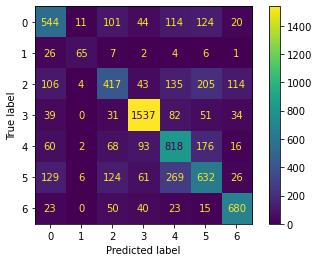

In [20]:
from sklearn.metrics import confusion_matrix , classification_report ,ConfusionMatrixDisplay
CLASS_LABELS  = [0,1,2,3,4,5,6]
cm_data = confusion_matrix(test_labels_new , preds_labels_new,labels=CLASS_LABELS)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_data,
                              display_labels=CLASS_LABELS)
disp.plot()
plt.show()

In [21]:
# accuracy of class 2: 41.4%
# accuracy of class 5: 49.2%
# if the accuracies of class2 and class5 improve to 60%, the whole accuracy will improve to 
# nearly 70%, if the accuracies of class2 and class5 improve to 72%
# is there a way to train another model which emphasizes the accuracy of class 2 and class 5
# for example, to largely increase the weight of class 2 and class 5
# put large penalty when class 2 and class 5 are misclassified and other classes are misclassified to be class 2 and class 5

4693/7178

0.6538032878239064